# Regression Analysis: Height Data

### Python Setup

In [2]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from patsy import dmatrices

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")
%matplotlib inline

### Data

In [6]:
github ="https://raw.githubusercontent.com/kirenz/datasets/master/height.csv"

df = pd.read_csv(github)
np.random.seed(12) # aktuellen Zustand der Zufallsfunktion speichern -> gleiche Zahl erzeugen, auch wenn Code mehrmals ausgeführt wird

df["id"] = pd.Categorical(df["id"])
df["height_m"] = df.height/100 # calculate height in m (from cm)
df["weight"] = round(np.random.normal(45, 5, 20) * df["height_m"], 2)
df["bmi"] = round(df.weight / (df.height_m * df.height_m), 2)

In [7]:
df["bmi_category"] = pd.cut(df["bmi"], # cut = kontinuierliche Variable in kategoriale Variable umwandeln
                            bins=[0, 18.5, 25, 30, float("inf")],
                            labels=["underweight", "normal", "overweight", "obese"])

In [8]:
df

,name,id,height,average_height_parents,gender,height_m,weight,bmi,bmi_category
0,Stefanie,1,162,161,female,1.62,76.73,29.24,overweight
1,Peter,2,163,163,male,1.63,67.80,25.52,overweight
2,Stefanie,3,163,163,female,1.63,75.33,28.35,overweight
3,Manuela,4,164,165,female,1.64,59.85,22.25,normal
4,Simon,5,164,163,male,1.64,79.98,29.74,overweight
5,Sophia,6,164,164,female,1.64,61.22,22.76,normal
6,Ellen,7,164,164,female,1.64,73.84,27.45,overweight
7,Emilia,8,165,165,female,1.65,73.26,26.91,overweight
8,Lina,9,165,165,female,1.65,67.59,24.83,normal
9,Marie,10,165,165,female,1.65,97.94,35.97,obese


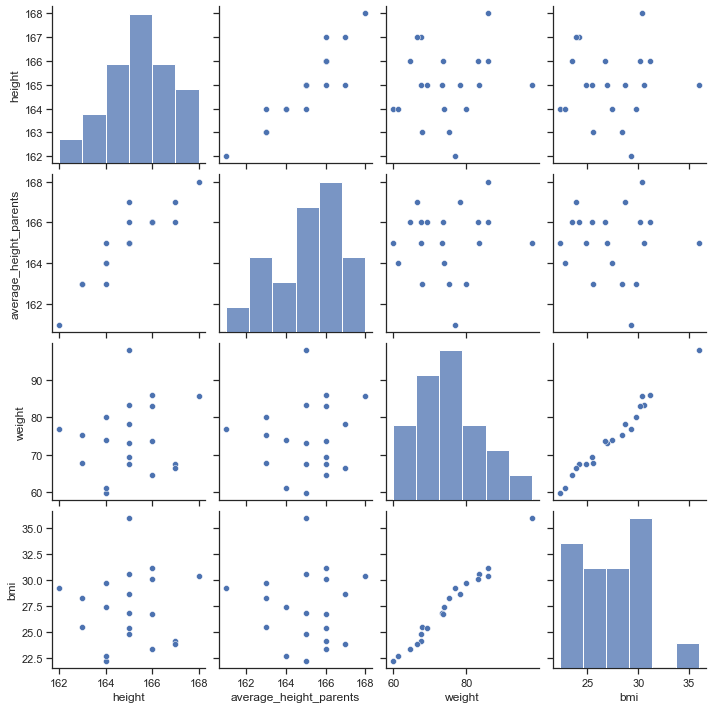

In [9]:
# plot numerical data as pairs
sns.pairplot(df, vars=["height", "average_height_parents", "weight", "bmi"]);

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
height,20.0,165.0000,1.486784,162.00,164.0000,165.000,166.000,168.00
average_height_parents,20.0,165.0500,1.669384,161.00,164.0000,165.000,166.000,168.00
height_m,20.0,1.6500,0.014868,1.62,1.6400,1.650,1.660,1.68
weight,20.0,74.5685,9.536019,59.85,67.5725,73.765,80.760,97.94
bmi,20.0,27.3870,3.453915,22.25,24.6750,27.180,29.845,35.97


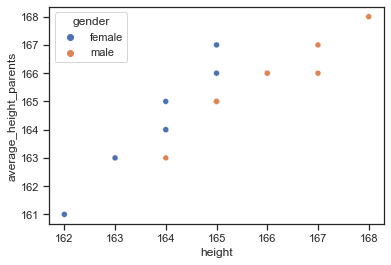

In [11]:
sns.scatterplot(data=df, x="height", y="average_height_parents", hue="gender");

### Regression Model 1

In [12]:
fit = smf.ols(formula="height ~ average_height_parents", data=df).fit()

In [13]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     88.78
Date:                Tue, 05 Apr 2022   Prob (F-statistic):           2.21e-08
Time:                        11:43:40   Log-Likelihood:                -17.995
No. Observations:                  20   AIC:                             39.99
Df Residuals:                      18   BIC:                             41.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 30

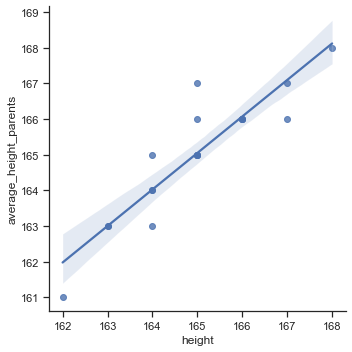

In [14]:
sns.lmplot(data=df, x="height", y="average_height_parents");

In [15]:
# create an out of sample value for height parents of 165
df_new = pd.DataFrame({"average_height_parents" : [165] })

df_new

,average_height_parents
0,165


In [16]:
# predistion for out of sample
prediction = fit.get_prediction(df_new["average_height_parents"])

In [17]:
prediction.summary_frame(alpha=0.05) # obtain summary inclusing a 95% confidence intervall (alpha=0.05) with the prediction result (mean), standard error (mean_se) and confidence intervalls (mean_ci)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,164.959396,0.140307,164.664622,165.254169,163.609181,166.30961


##### Residuals

Sum of squared residuals:

In [18]:
fit.ssr

7.080264400377715

- Mean squared Error (MSE) is the mean of SSR
- The root mean squared error (RMSE) is the root of MSE

In [19]:
# mean squared error
fit.mse_resid

0.39334802224320636

In [20]:
# root mean squared error
np.sqrt(fit.mse_resid)

0.627174634566168

##### Diagnostics

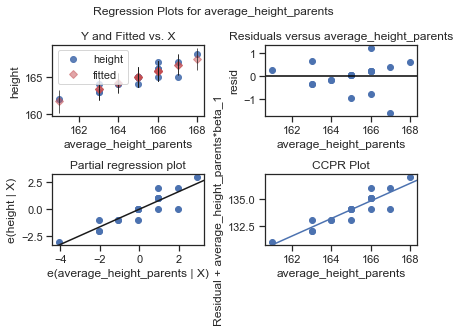

In [21]:
fig = sm.graphics.plot_regress_exog(fit, "average_height_parents")
fig.tight_layout(pad=1.0)

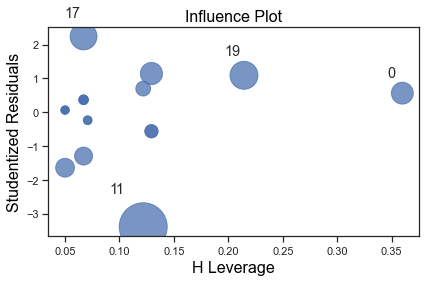

In [22]:
fig = sm.graphics.influence_plot(fit, criterion="cooks")
fig.tight_layout(pad=1.0)

In [24]:
# obtain cook´s distance
fit_cooksd = fit.get_influence().cooks_distance[0]

# get length of DataFrame to obtain n
n = len(df["height"])

# calculate critical d
critical_d = 4/n
print("Critical Cooks Distance", critical_d)

# identification of potential outliers with leverage
out_d = fit_cooksd > critical_d

# output potential outliers with leverage
print(df.index[out_d], "\n", 
    fit_cooksd[out_d])

Critical Cooks Distance 0.2
Int64Index([11], dtype='int64') 
 [0.50348555]


In [25]:
df.iloc[11]

name                            Mila
id                                12
height                           165
average_height_parents           167
gender                        female
height_m                        1.65
weight                         78.15
bmi                            28.71
bmi_category              overweight
Name: 11, dtype: object